# XGBRegression (LMA features to P,A,D coordinates)

In [1]:
# Current best:
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 11, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.05, 'alpha': 0.25}

## Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
from mpl_toolkits import mplot3d

## Load Data

In [22]:
dataset = pd.read_csv('datasets/S_BANDAI_5frame.csv')
print(dataset.shape)

(78551, 28)


### Split into Test and Train data

In [23]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 62841
No Test Samples: 15710


### Split Features from Targets

In [24]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [25]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
12441,1.288684,0.496127,0.842929,-1.489973,1.069144,1.037626,1.044265,1.145085,-0.234499,0.650071,...,-0.178807,-0.668111,-1.381085,0.347578,-0.430127,-0.536139,-0.447496,-0.306034,-0.553123,-0.367299
38901,0.231150,-0.187718,-0.124120,-0.335513,0.686997,0.427352,0.229231,0.152233,0.384847,-0.296090,...,0.881930,0.064042,-0.543981,0.869477,0.527940,-0.604786,-0.647161,-0.314649,-0.630457,-0.144010
61417,-1.751812,-1.134810,-2.333610,-0.076950,-0.896584,-1.079796,-1.979791,-1.420267,-0.667012,0.907185,...,0.263257,1.029968,0.980305,0.126811,0.556686,-0.533482,-0.355734,-0.010879,-0.238030,-0.367790
38505,1.757132,1.593749,0.835202,2.034977,1.311138,1.167416,1.722761,1.256541,0.685499,0.971273,...,-0.013991,0.038385,0.517011,0.105097,-0.340512,-0.549077,-0.101872,-0.122968,0.495447,0.190720
44847,1.372656,0.659474,0.778535,-0.090735,1.072560,1.351404,1.160399,1.170234,1.235589,-0.843714,...,0.750662,-0.243611,-0.525213,0.780695,0.174450,-0.224381,-0.440155,-0.408984,-0.547992,-0.324652


In [26]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
12441,0.3,0.40,0.6
38901,0.2,-0.75,-0.3
61417,0.3,0.40,0.6
38505,0.1,0.60,0.4
44847,0.3,0.40,0.6


In [27]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,-0.002797,0.999650
avg_l_hand_hip_distance,0.001174,1.000542
avg_r_hand_hip_distance,-0.001272,0.998894
max_stride_length,-0.001829,0.999228
avg_l_hand_chest_distance,-0.002029,1.000883
avg_r_hand_chest_distance,-0.003010,1.002036
avg_l_elbow_hip_distance,-0.000239,0.998970
avg_r_elbow_hip_distance,0.000372,1.000448
avg_chest_pelvis_distance,-0.001018,0.993583
avg_neck_chest_distance,-0.000657,0.999284


## Define Model

In [28]:
xgbr = xgb.XGBRegressor(verbosity=1) 

params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

# maybe add gamma? this seems to be overfitting a bit 
model_p = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=15, min_child_weight=5, 
                    reg_alpha=0.25, reg_lambda=1.25, gamma=0.001,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )


#{'subsample': 1,'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}
model_a = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=15, min_child_weight=11, 
                    reg_alpha=0.25, reg_lambda=1.25, gamma=0.0,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
        
    
#{subsample': 1}
model_d = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.25, reg_lambda=1.0, gamma=0.0,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

## Train Model

### Pleasure Regression

In [29]:
model_p.fit(train_X, train_y_p)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.001, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.25, reg_lambda=1.25,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Arousal Regression

In [30]:
model_a.fit(train_X, train_y_a)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=15,
             min_child_weight=11, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.25, reg_lambda=1.25,
             scale_pos_weight=1, subsample=1.0, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Dominance Regression

In [31]:
model_d.fit(train_X, train_y_d)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.25, reg_lambda=1.0,
             scale_pos_weight=1, subsample=1.0, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

## Test Model

### Training Score

In [32]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

score = model_d.score(train_X, train_y_d)  

print()

print("Dominance")
print("Training score: ", score)

Pleasure
Training score:  0.9960249850639907

Arousal
Training score:  0.9984486063050011

Dominance
Training score:  0.9990319999399025


### Test Set MAE & MSE

In [33]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nDominance")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.00
MAE: 0.03

Arousal
MSE: 0.01
MAE: 0.05

Dominance
MSE: 0.01
MAE: 0.04


### Graphs

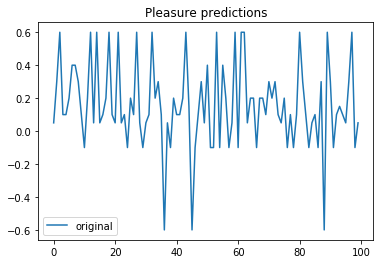

In [34]:
x_ax = range(100)
plt.plot(x_ax, test_y_p[0:100], label="original")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

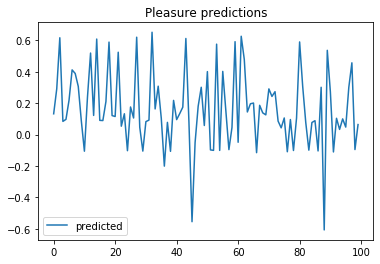

In [35]:
x_ax = range(100)
plt.plot(x_ax, pred_y_p[0:100], label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

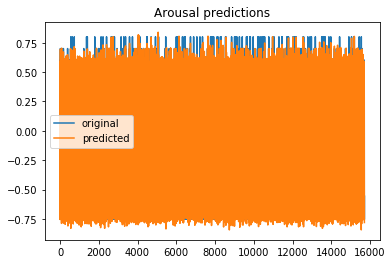

In [82]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, test_y_a, label="original")
plt.plot(x_ax, pred_y_a, label="predicted")

plt.title("Arousal predictions")

plt.legend()
plt.show()

### Prediction Examples

In [36]:
row=test_X.iloc[1]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[1]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [0.3 0.4 0.6]
Predicted: [0.29113764, 0.39924127, 0.59288174]


In [37]:
row=test_X.iloc[421]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[421]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [0.3 0.4 0.6]
Predicted: [0.3160658, 0.40294465, 0.5876449]


In [38]:
row=test_X.iloc[999]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[999]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [0.6 0.4 0.1]
Predicted: [0.60455906, 0.41558823, 0.1160015]


## Save Models

In [39]:
# save to JSON
model_p.save_model("models/bandai_l2p_model_2.json")
model_a.save_model("models/bandai_l2a_model.json")
model_d.save_model("models/bandai_l2d_model.json")

## Load Models

In [87]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("models/bandai_l2p_model.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("models/bandai_l2a_model.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("models/bandai_l2d_model.json")

### Graphs

In [88]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.00
MAE: 0.02

Arousal
MSE: 0.01
MAE: 0.05

Arousal
MSE: 0.01
MAE: 0.04


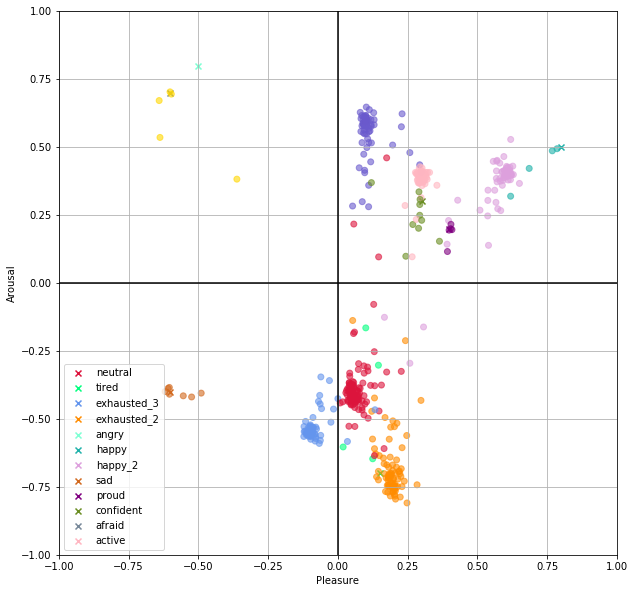

In [89]:
x = pred_y_p[0:500]
y = pred_y_a[0:500]
z = pred_y_d[0:500]

x_reference = [
    0.05,
    0.15,
    -0.1,
    0.2,
    -0.5,
    0.8,
    0.6,
    -0.6,
    0.4,
    0.3,
    -0.6,
    0.1,
]

y_reference = [
    -0.4,
    -0.7,
    -0.55,
    -0.75,
    0.8,
    0.5,
    0.4,
    -0.4,
    0.2,
    0.3,
    0.7,
    0.6,
]


colors_reference = ["crimson", "springgreen", "cornflowerblue", 
                    "darkorange", 
                    "aquamarine", 
                    "lightseagreen", "plum", "chocolate", "purple", "olivedrab", "lightslategray",
                    "lightpink", "gold", "slateblue"]

colors = []

color_map = {
    (0.05, -0.4): "crimson",
    (0.15, -0.7): "springgreen",
    (-0.1, -0.55): "cornflowerblue",
    (0.2, -0.75): "darkorange",
    (-0.5, 0.8): "aquamarine",
    (0.8, 0.5): "lightseagreen",
    (0.6, 0.4): "plum",
    (-0.6, -0.4): "chocolate",
    (0.4, 0.2): "purple", 
    (0.3, 0.3): "olivedrab", 
    (0.25, 0.15): "lightslategray",
    (0.3, 0.4): "lightpink", 
    (-0.6, 0.7): "gold",
    (0.1, 0.6): "slateblue", 
}


conv_dict = {
    (0.05, -0.4): "neutral",
    (0.15, -0.7): "tired",
    (-0.1, -0.55): "exhausted",
    (0.2, -0.75): "exhausted_2",
    (-0.1, -0.55): "exhausted_3", 
    (-0.5, 0.8): "angry",
    (0.8, 0.5): "happy",
    (0.6, 0.4): "happy_2",
    (-0.6, -0.4): "sad",
    (0.4, 0.2): "proud", 
    (0.3, 0.3): "confident", 
    (0.25, 0.15): "confident_2",
    (0.25, 0.15): "confident_3",
    (0.3, 0.4): "confident_4", 
    (-0.6, 0.7): "afraid",
    (0.1, 0.6): "active", 
}


for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i])
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(x_reference[i], y_reference[i], c=colors_reference[i], label=conv_dict[(x_reference[i], y_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Pleasure')
plt.ylabel('Arousal')
plt.grid(True)

plt.show()



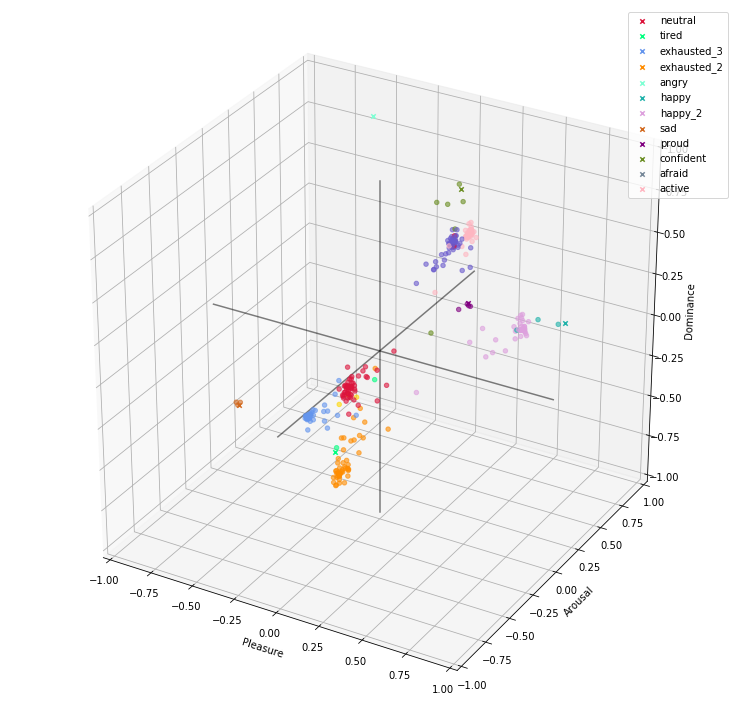

In [90]:
x = pred_y_p[0:300]
y = pred_y_a[0:300]
z = pred_y_d[0:300]

x_reference = [
    0.05,
    0.15,
    -0.1,
    0.2,
    -0.5,
    0.8,
    0.6,
    -0.6,
    0.4,
    0.3,
    -0.6,
    0.1,
]

y_reference = [
    -0.4,
    -0.7,
    -0.55,
    -0.75,
    0.8,
    0.5,
    0.4,
    -0.4,
    0.2,
    0.3,
    0.7,
    0.6,
]

z_reference = [
    0.0,
    -0.2,
    -0.15,
    -0.3,
    0.9,
    0.15,
    0.1,
    -0.3,
    0.3,
    0.9,
    -0.8,
    0.4,
]

colors_reference = ["crimson", "springgreen", "cornflowerblue", 
                    "darkorange", 
                    "aquamarine", 
                    "lightseagreen", "plum", "chocolate", "purple", "olivedrab", "lightslategray",
                    "lightpink", "gold", "slateblue"]

colors = []


color_map = {
    (0.05, -0.4, 0.0): "crimson",
    (0.15, -0.7, -0.2): "springgreen",
    (-0.1, -0.55, -0.15): "cornflowerblue",
    (0.2, -0.75, -0.3): "darkorange",
    (-0.5, 0.8, 0.9): "aquamarine",
    (0.8, 0.5, 0.15): "lightseagreen",
    (0.6, 0.4, 0.1): "plum",
    (-0.6, -0.4, -0.3): "chocolate",
    (0.4, 0.2, 0.3): "purple", 
    (0.3, 0.3, 0.9): "olivedrab", 
    (0.25, 0.15, 0.3): "lightslategray",
    (0.3, 0.4, 0.6): "lightpink", 
    (-0.6, 0.7, -0.8): "gold",
    (0.1, 0.6, 0.4): "slateblue", 
}


conv_dict = {
    (0.05, -0.4, 0.0): "neutral",
    (0.15, -0.7, -0.2): "tired",
    (-0.1, -0.55, -0.15): "exhausted",
    (0.2, -0.75, -0.3): "exhausted_2",
    (-0.1, -0.55, -0.15): "exhausted_3", 
    (-0.5, 0.8, 0.9): "angry",
    (0.8, 0.5, 0.15): "happy",
    (0.6, 0.4, 0.1): "happy_2",
    (-0.6, -0.4, -0.3): "sad",
    (0.4, 0.2, 0.3): "proud", 
    (0.3, 0.3, 0.9): "confident", 
    (0.25, 0.15, 0.3): "confident_2",
    (0.25, 0.15, 0.3): "confident_3",
    (0.3, 0.4, 0.6): "confident_4", 
    (-0.6, 0.7, -0.8): "afraid",
    (0.1, 0.6, 0.4): "active", 
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i], test_y_d.iloc[i])
    
    colors.append(color_map[point_coords])

fig = plt.figure(figsize = (13, 13))
ax = plt.axes(projection ="3d")


for i in range(len(x_reference)):
    ax.scatter3D(x_reference[i], y_reference[i], z_reference[i], 
               c=colors_reference[i], 
               label=conv_dict[(x_reference[i], y_reference[i], z_reference[i])],
               marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, z, c=colors, alpha=0.6)


line = mplot3d.art3d.Line3D([-1, 1], [0, 0], [0,0], color='black', alpha=0.5)
line_2 = mplot3d.art3d.Line3D([0, 0], [-1, 1], [0,0], color='black', alpha = 0.5)
line_3 = mplot3d.art3d.Line3D([0, 0], [0, 0], [-1,1], color='black', alpha = 0.5)

ax.add_line(line)
ax.add_line(line_2)
ax.add_line(line_3)


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('Pleasure')
ax.set_ylabel('Arousal')
ax.set_zlabel('Dominance')
plt.grid(True)

plt.show()



# Hyperparameter Grid Search with XGBoost

In [3]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error


import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

## Load Data

In [4]:
dataset = pd.read_csv('datasets/S_BANDAI_05sec.csv')

### Split into Test and Train data

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 20829
No Test Samples: 5207


### Split Features from Targets

In [6]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [7]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
25444,-1.484877,-0.828347,-1.234174,-0.661269,-0.124149,-0.232081,-0.981639,-0.881532,-0.537928,-0.535852,...,-1.108413,0.020610,-0.136050,-0.963477,-0.637230,-0.592533,-0.406729,-0.252699,-0.140690,-0.626200
11015,-1.635016,-2.204550,-1.287023,-0.335370,-1.077325,-0.811338,-1.478880,-1.864274,0.187813,0.438460,...,-1.001587,-0.005483,0.008179,-1.014404,-0.442169,-0.253266,-0.450049,-0.008086,0.425267,-0.345013
6424,0.319941,-0.482794,0.705833,0.315663,0.256356,1.240658,0.323679,0.918516,-0.247325,-0.369521,...,-0.565608,-0.247005,-0.575852,-0.619057,-0.234824,-0.951172,-0.476015,-0.208034,0.210554,-0.319913
3090,-0.617475,0.842859,-0.913038,2.879592,-0.241820,-1.905904,-1.771665,0.566861,0.715976,1.765119,...,-1.555212,-1.538433,-1.413717,-1.422897,-1.693396,-1.274620,-1.222962,-1.285185,-1.295725,-1.136119
4656,-0.424755,-0.412196,-0.078287,0.994076,-0.934271,-0.659510,0.682060,0.667631,-0.360533,-0.012634,...,0.992739,1.734505,1.957553,0.203789,1.176809,0.286130,-0.743247,0.796868,1.162976,-0.088302


In [8]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
25444,0.05,-0.4,0.0
11015,0.30,0.4,0.6
6424,-0.50,0.8,0.9
3090,0.10,0.6,0.4
4656,0.05,-0.4,0.0


In [9]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,0.000612,0.997648
avg_l_hand_hip_distance,0.004801,0.999230
avg_r_hand_hip_distance,0.001350,1.000538
max_stride_length,-0.000102,0.995341
avg_l_hand_chest_distance,0.002424,0.999286
avg_r_hand_chest_distance,-0.000689,1.002142
avg_l_elbow_hip_distance,0.004961,1.000104
avg_r_elbow_hip_distance,0.004294,0.997386
avg_chest_pelvis_distance,0.000335,1.004072
avg_neck_chest_distance,-0.000447,1.003000


## RandomSearchCV

In [10]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 150

In [11]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [12]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = RandomizedSearchCV(model_p, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 21804.13 seconds for 150 candidates parameter settings.


In [13]:
# Arousal
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = RandomizedSearchCV(model_a, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 27209.98 seconds for 150 candidates parameter settings.


In [14]:
# Dominance
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = RandomizedSearchCV(model_d, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 21206.05 seconds for 150 candidates parameter settings.


### Results

In [15]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}


In [16]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}


In [17]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}


In [18]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.01
MAE: 0.04


Arousal
MSE: 0.02
MAE: 0.08


Arousal
MSE: 0.01
MAE: 0.05


### Predictions

In [19]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [ 0.2  -0.75 -0.3 ]
Predicted: [0.19121394, -0.6511988, -0.2671447]


In [20]:
# save to JSON
best_regressor_p.save_model("models/bandai_l2p_model_05sec.json")
best_regressor_a.save_model("models/bandai_l2a_model_05sec.json")
best_regressor_d.save_model("models/bandai_l2d_model_05sec.json")

## GridSearchCV

In [128]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }
#params = {
#        'n_estimators': [1000, 2000],
#        'min_child_weight': [10, 25],
#        'gamma': [0, 0.005, 0.01],
#        'learning_rate': [0.01, 0.07, 0.1],
#        'max_depth': [10, 20],
#        'lambda': [1, 1.25],
#        'alpha': [0.0, 0.25]
#        }

In [129]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [130]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = GridSearchCV(model_p, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

GridSearchCV took 34187.72 seconds parameter settings.


In [131]:
# Arousal
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = GridSearchCV(model_a, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 33562.72 seconds for 100 candidates parameter settings.


In [ ]:
# Dominance
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = GridSearchCV(model_d, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

### Results

In [83]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}


In [84]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.0}


In [85]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}


In [86]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.03
MAE: 0.06


Arousal
MSE: 0.02
MAE: 0.05


Arousal
MSE: 0.04
MAE: 0.07


### Predictions

In [144]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.5 -0.7]
Predicted: [-0.542336, -0.690465]
